In [108]:
import tensorflow as tf
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np

In [29]:
train_dir = "./data/train/"
val_dir = "./data/valid/"
test_dir = "./data/test/"

In [30]:
train_ann = train_dir + "_annotations.coco.json"
val_ann = val_dir + "_annotations.coco.json"
test_ann = test_dir + "_annotations.coco.json"

In [31]:
train_coco = COCO(train_ann)
val_coco = COCO(val_ann)
test_coco = COCO(test_ann)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [50]:
train_size = len(train_coco.imgs)
val_size = len(val_coco.imgs)
test_size = len(test_coco.imgs)

print("Train size:", train_size)
print("Validation size:", val_size)
print("Test size:", test_size)

Train size: 1502
Validation size: 429
Test size: 215


In [62]:
def set_up_data(coco, size):
    paths = []
    categories = []
    for i in range(size):
        paths.append(coco.imgs[i]["file_name"])
        categories.append(coco.anns[i]["category_id"])

    return paths, categories

In [65]:
def read_image(directory, image_path):
    image = tf.io.read_file(directory + image_path)
    image = tf.image.decode_image(image, channels=1, dtype=tf.float32)
    return image

In [109]:
def get_data(coco, size, directory):
    paths, categories = set_up_data(coco, size)
    images = []
    for i in range(size):
        image = read_image(directory, paths[i])
        images.append(image)

    masks = []
    for i in range(size):
        ann = coco.anns[i]
        mask = coco.annToMask(ann)
        masks.append(mask)
    
    x_train = tf.convert_to_tensor(images, dtype=tf.float32)
    y_train = tf.convert_to_tensor(masks, dtype=tf.float32)
    return x_train, y_train

In [110]:
x_train, y_train = get_data(train_coco, train_size, train_dir)
x_val, y_val = get_data(val_coco, val_size, val_dir)
x_test, y_test = get_data(test_coco, test_size, test_dir)

In [130]:
def show_images(images, masks, number_of_images):
    number_iterations = min(len(images), number_of_images)
    
    fig, ax = plt.subplots(number_iterations, 2, figsize=(5, number_iterations * 5))
    
    for i in range(number_iterations):
        ax[i][0].imshow(images[i], cmap="gray")
        ax[i][1].imshow(masks[i], cmap="gray")

        ax[i][0].set_title(f"Image {i+1}")
        ax[i][1].set_title(f"Mask {i+1}")

    plt.show()

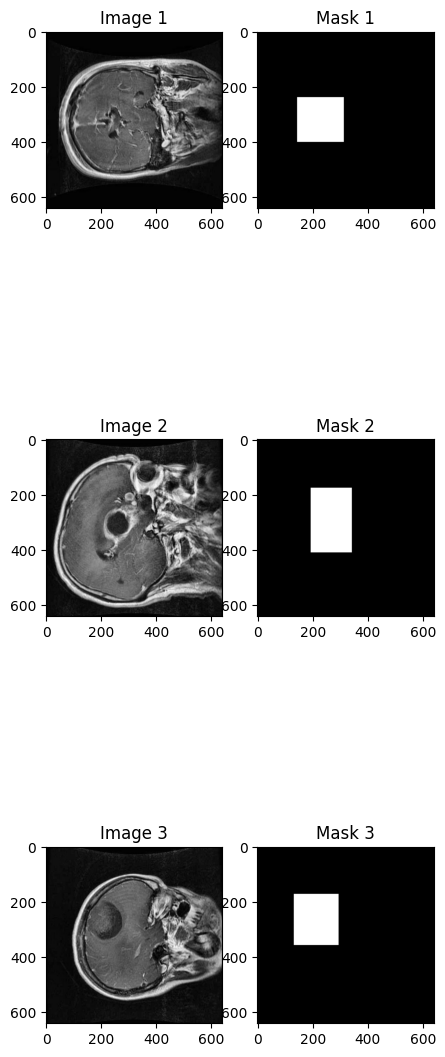

In [131]:
show_images(x_train, y_train, 3)

In [137]:
def preprocess_data(images):
    # Normalizing the input
    images = images / 255.
    return images

In [135]:
x_train = preprocess_data(x_train)
x_val = preprocess_data(x_val)
x_test = preprocess_data(x_test)

In [138]:
# Now that the data is ready, it's time to train the model

In [143]:
def down_block(x, n_filters, dropout_prob=0.0, want_max_pooling=True):
    
    out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding="same")(x)
    out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding="same")(out)

    if dropout_prob > 0.0:
        out = tf.keras.layers.Dropout(dropout_prob)(out)

    skip_connection = out

    if want_max_pooling:
        out = tf.keras.layers.MaxPool2D(pool_size=2)(out)

    return out, skip_connection

In [144]:
def up_block(x, skip_connection, n_filters):
    out = tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=3, strides=2, padding="same")(x)

    #Concatenate skip connection
    out = tf.keras.layers.Concatenate()([out, skip_connection])

    out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding="same")(out)
    out = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=3, padding="same")(out)
    return out

In [170]:
def unet_model(input_shape, n_classes, n_filters):
    inputs = tf.keras.Input(shape=input_shape)

    # Down Block
    out1, skip_connection1 = down_block(inputs, n_filters)
    out2, skip_connection2 = down_block(out1, 2 * n_filters)
    out3, skip_connection3 = down_block(out2, 4 * n_filters)
    out4, skip_connection4 = down_block(out3, 8 * n_filters)
    out5, skip_connection5 = down_block(out4, 16 * n_filters, want_max_pooling=False)

    # Up Block
    up1 = up_block(out5, skip_connection4, 8 * n_filters)
    up2 = up_block(up1, skip_connection3, 4 * n_filters)
    up3 = up_block(up2, skip_connection2, 2 * n_filters)
    up4 = up_block(up3, skip_connection1, n_filters)

    outputs = tf.keras.layers.Conv2D(filters=n_classes, kernel_size=1, padding="same")(up4)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [180]:
width = x_train.shape[1]
height = x_train.shape[2]
n_channels = x_train.shape[3]
n_classes = 1
n_filters = 32
input_shape = (width, height, n_channels)

In [181]:
model = unet_model(input_shape, n_classes, n_filters)

In [182]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 640, 640, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_48 (Conv2D)            │ (None, 640, 640, 32)      │             320 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_49 (Conv2D)            │ (None, 640, 640, 32)      │           9,248 │ conv2d_48[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_13              │ (None, 320, 320, 32)      │               0 │ conv2d_49[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_50 (Conv2D)            │ (None, 320, 320, 64)      │          18,496 │ max_pooling2d_13[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_51 (Conv2D)            │ (None, 320, 320, 64)      │          36,928 │ conv2d_50[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_14              │ (None, 160, 160, 64)      │               0 │ conv2d_51[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_52 (Conv2D)            │ (None, 160, 160, 128)     │          73,856 │ max_pooling2d_14[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_53 (Conv2D)            │ (None, 160, 160, 128)     │         147,584 │ conv2d_52[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_15              │ (None, 80, 80, 128)       │               0 │ conv2d_53[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_54 (Conv2D)            │ (None, 80, 80, 256)       │         295,168 │ max_pooling2d_15[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_55 (Conv2D)            │ (None, 80, 80, 256)       │         590,080 │ conv2d_54[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_16              │ (None, 40, 40, 256)       │               0 │ conv2d_55[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_56 (Conv2D)            │ (None, 40, 40, 512)       │       1,180,160 │ max_pooling2d_16[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_57 (Conv2D)            │ (None, 40, 40, 512)       │       2,359,808 │ conv2d_56[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,629,921 (32.92 MB)

 Trainable params: 8,629,921 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

In [183]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-2),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)

In [ ]:
model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 5,
    validation_data = (x_val, y_val),
)

Epoch 1/5
